# Разработка модели для предсказания продолжения деятельности стартапа. 


В наличии для обучения модели были взяты данные о стартапах, функционировавших в период с 1980 г. по 2018 г. Основная задача это обучение рабочей модели для предсказания закрытия компании стартапа или продолжения её деятельности. 
Работа состоит из следующих этапов:
1. Загрузка исследуемых данных;
2. Предобработка данных;
3. Исследовательский анализ данных;
4. Проверка признаков на мультиколлинеарность;
5. Подготовка модели к обучению;
6. Обучение модели на тренировочной выборке и на тестовой;
7. Анализ важности признаков;
8. Отчет о проделанной работе и возможные рекомендации.

<div class='alert-info'>
    Ревьюеру привет), синим цветом отмечу свой комментарии, если они будут.

### 1. Загрузка и первичный осмотр данных.

In [1]:
#импортируем необходимые для работы библиотеки и инструменты из них
import numpy as np
import pandas as pd
import shap
import phik
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler
                                  )
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, fbeta_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

RANDOM_STATE = 42
TEST_SIZE = 0.25

In [2]:
#загружаем данные для модели
pth1 = 'D:\project\M1_DS - Startups (STD)\kaggle_startups_train_28062024.csv'
pth2 = 'D:\project\M1_DS - Startups (STD)\kaggle_startups_test_28062024.csv'
train_data = pd.read_csv(pth1)
test_data = pd.read_csv(pth2)
#отобразим информацию в таблицах для первичного ознакомления
print('Таблица со стартапами для тренировочной выборки')
display(train_data.head(), train_data.shape)
print('Таблица со стартапами для тестовой выборки')
display(test_data.head(), test_data.shape)

Таблица со стартапами для тренировочной выборки


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


(52516, 13)

Таблица со стартапами для тестовой выборки


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


(13125, 11)

Выведем общую информацию по таблицам

In [3]:
#проверим общую информацию о таблицах 
print('Таблица с признаками для тренировочной выборки')
display(train_data.info())
print('Таблица с признаками для тестовой выборки')
display(test_data.info())

Таблица с признаками для тренировочной выборки
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


None

Таблица с признаками для тестовой выборки
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


None

В датасетах видно наличие пропусков - для некоторых компаний отсутствуют названия страны, регионов(штатов), городов, названия категорий которые могут характеризовать деятельность компании, а также общее число вложенных средств в компанию. 

Теперь стоит разобраться с этими пропусками и проверим наличие дубликатов.
Колонки с датой стоит преобразовать в тип datetime, чтобы pandas мог его корректно обрабатывать.

### 2. Предобработка данных.

Проверим пропуски в таблицах и число полных дубликатов

In [4]:
#для проверки используем функцию
def completeness_check(ittor, table):
    print('Пропусков в таблице', table)
    print(ittor.isna().sum())
    value = ittor.duplicated().sum()
    print(f'Полных дубликатов в таблице {table} - {value}')

In [5]:
#проверим таблицу с тренировочными данными
completeness_check(train_data, 'с тренировочными данными')

Пропусков в таблице с тренировочными данными
name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64
Полных дубликатов в таблице с тренировочными данными - 0


In [6]:
#проверим таблицу с тестовыми данными
completeness_check(test_data, 'с тестовыми данными')

Пропусков в таблице с тестовыми данными
name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64
Полных дубликатов в таблице с тестовыми данными - 0


Так как пропусков в таблице очень много и удалять их будет большой потерей для обучения модели, заменим их "заглушки", чтобы сохранить информацию в других колонках.  
Для колонки с категориями, с кодом страны, со штатом, регионом и городом пропуски станут "other_category", "other_country_code" или коротко "OCC", "other_state", "other_region" и "other_city" соответственно.  

Пропуски в колонке с суммой вложенной средств заполним медианным значением. 
Строку с пропущенным названием компании можно удалить без потери.  
Пропуски в колонке с закрытием компании можно изменить исходя из логики, что если компания все еще работает и даты закрытия нет, то можно вместо пропуска написать "still_working"(еще_работает). Приводить к типу данных datetime[64] не имеет смысла, т.к. эта колонка не будет участвовать в обучении модели из-за отсутствия влияния на статус компании. 

Начнем с тренировочного датасета

In [7]:
#избавимся от пропуска с названием
train_data = train_data.dropna(subset=['name'])

In [8]:
#заменим пропуски: в колонке с категориями
train_data['category_list'] = train_data['category_list'].fillna('other_category')
#-в колонке cо страной
train_data['country_code'] = train_data['country_code'].fillna('OCC')
#-в колонке со штатом
train_data['state_code'] = train_data['state_code'].fillna('other_state')
#-в колонке с регионом
train_data['region'] = train_data['region'].fillna('other_region')
#-в колонке с городом
train_data['city'] = train_data['city'].fillna('other_city')
#-в колонке с датой закрытия
train_data['closed_at'] = train_data['closed_at'].fillna('still_working')
#проверим результат выведя 20 строк из таблицы и посчитаем пропуски снова
train_data['funding_total_usd'] = train_data['funding_total_usd'].fillna(train_data['funding_total_usd'].median())
display(train_data.head(20))
completeness_check(train_data, 'с тренировочными данными')

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,8.286260e+05,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,still_working
1,EarLens,Manufacturing|Medical|Medical Devices,4.293502e+07,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,still_working
2,Reviva Pharmaceuticals,Biotechnology,3.545638e+07,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,still_working
3,Sancilio and Company,Health Care,2.225000e+07,operating,OCC,other_state,other_region,other_city,3,2004-01-01,2011-09-01,2014-07-18,still_working
4,WireTough Cylinders,Manufacturing,2.000000e+06,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,still_working
5,Connected Sports Ventures,Mobile,4.300000e+06,operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,still_working
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,9.000000e+07,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,still_working
7,Mesh Networks,Software,4.300000e+06,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,still_working
8,AngioScore,Biotechnology,4.200000e+07,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,still_working
9,Vidatronic,Semiconductors,1.250500e+06,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,still_working


Пропусков в таблице с тренировочными данными
name                 0
category_list        0
funding_total_usd    0
status               0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
founded_at           0
first_funding_at     0
last_funding_at      0
closed_at            0
dtype: int64
Полных дубликатов в таблице с тренировочными данными - 0


Проделаем ту же операцию с тестовым датасетом

In [9]:
#заменим пропуски: в колонке с категориями
test_data['category_list'] = test_data['category_list'].fillna('other_category')
#-в колонке cо страной
test_data['country_code'] = test_data['country_code'].fillna('OCC')
#-в колонке со штатом
test_data['state_code'] = test_data['state_code'].fillna('other_state')
#-в колонке с регионом
test_data['region'] = test_data['region'].fillna('other_region')
#-в колонке с городом
test_data['city'] = test_data['city'].fillna('other_city')
#проверим результат выведя 20 строк из таблицы и посчитаем пропуски снова
test_data['funding_total_usd'] = test_data['funding_total_usd'].fillna(test_data['funding_total_usd'].median())
display(test_data.head(20))
completeness_check(test_data, 'с тренировочными данными')

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2.819200e+06,NIC,17,other_region,other_city,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,2.000000e+06,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,4.282570e+05,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,3.470000e+07,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4.530000e+06,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209
5,Quickfire Games,Design|Entertainment|Games,1.600000e+05,OCC,other_state,other_region,other_city,2,2013-09-18,2014-09-18,1583
6,Sente Inc.,Biotechnology,2.684200e+07,USA,CA,San Diego,Encinitas,5,2009-01-31,2014-06-02,4018
7,Triosyn,Health Care|Medical|Therapeutics,4.000000e+06,OCC,other_state,other_region,other_city,1,2003-06-02,2003-06-02,5576
8,Urgent.ly,Software,8.710000e+06,USA,VA,"Washington, D.C.",Sterling,3,2014-04-17,2015-09-29,1826
9,Map Decisions,Software,1.320000e+04,USA,PA,Allentown,Bethlehem,1,2013-08-09,2013-08-09,2057


Пропусков в таблице с тренировочными данными
name                 0
category_list        0
funding_total_usd    0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
first_funding_at     0
last_funding_at      0
lifetime             0
dtype: int64
Полных дубликатов в таблице с тренировочными данными - 0


В колонке с категориями проф-направления компании оставим только первую из перечисления, как основную для компаний.

In [10]:
train_data['new_category_list'] = train_data['category_list'].str.split('|').str.get(0)
train_data.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,new_category_list
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,still_working,Online Reservations
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,still_working,Manufacturing
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,still_working,Biotechnology
3,Sancilio and Company,Health Care,22250000.0,operating,OCC,other_state,other_region,other_city,3,2004-01-01,2011-09-01,2014-07-18,still_working,Health Care
4,WireTough Cylinders,Manufacturing,2000000.0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,still_working,Manufacturing


Проведем то же самое с тестовым датасетом.

In [11]:
test_data['new_category_list'] = test_data['category_list'].str.split('|').str.get(0)
test_data.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,new_category_list
0,Crystalsol,Clean Technology,2819200.0,NIC,17,other_region,other_city,1,2009-07-01,2009-07-01,3501,Clean Technology
1,JBI Fish & Wings,Hospitality,2000000.0,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,Hospitality
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,Finance
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748,Software
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209,Software


Изменим тип данных в колонках с датой

In [12]:
for i in ['founded_at', 'first_funding_at', 'last_funding_at']:
    train_data[i] = pd.to_datetime(train_data[i], format='%Y-%m-%d')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52515 entries, 0 to 52515
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      52515 non-null  object        
 2   funding_total_usd  52515 non-null  float64       
 3   status             52515 non-null  object        
 4   country_code       52515 non-null  object        
 5   state_code         52515 non-null  object        
 6   region             52515 non-null  object        
 7   city               52515 non-null  object        
 8   funding_rounds     52515 non-null  int64         
 9   founded_at         52515 non-null  datetime64[ns]
 10  first_funding_at   52515 non-null  datetime64[ns]
 11  last_funding_at    52515 non-null  datetime64[ns]
 12  closed_at          52515 non-null  object        
 13  new_category_list  52515 non-null  object        
dtypes: dat

In [13]:
#изменим типы данных в тестовой таблице
for i in ['first_funding_at', 'last_funding_at']:
    test_data[i] = pd.to_datetime(test_data[i], format='%Y-%m-%d')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      13125 non-null  object        
 2   funding_total_usd  13125 non-null  float64       
 3   country_code       13125 non-null  object        
 4   state_code         13125 non-null  object        
 5   region             13125 non-null  object        
 6   city               13125 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
 11  new_category_list  13125 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(7)
memory usage: 1.2+ MB


**Проверим теперь данные на дубликаты явные и неявные**

In [14]:
# добавим функцию для выявления 
train_object_type = train_data.select_dtypes('object').columns
def unique_check(data, ittor):
    for i in ittor:
        print(f'Cтолбец: - {i}')
        print(data[i].sort_values().unique())
        value = data[i].duplicated().sum()
        print(f'Уникальных значений в колонке {i} - {len(data[i]) - value}')
        

In [15]:
unique_check(train_data, train_object_type)

Cтолбец: - name
['#BratPackStyle, LLC.' '#fame' '&TV Communications' ... '\u200bShwrüm'
 '\u200bWestEd' '吃神马 ChiShenMa']
Уникальных значений в колонке name - 52515
Cтолбец: - category_list
['3D' '3D Printing' '3D Printing|3D Technology' ... 'mHealth|Software'
 'mHealth|Software|Therapeutics' 'other_category']
Уникальных значений в колонке category_list - 22106
Cтолбец: - status
['closed' 'operating']
Уникальных значений в колонке status - 2
Cтолбец: - country_code
['ALB' 'ARE' 'ARG' 'ARM' 'AUS' 'AUT' 'AZE' 'BAH' 'BEL' 'BGD' 'BGR' 'BHR'
 'BLM' 'BLR' 'BLZ' 'BMU' 'BRA' 'BRN' 'BWA' 'CAN' 'CHE' 'CHL' 'CHN' 'CMR'
 'COL' 'CRI' 'CYM' 'CYP' 'CZE' 'DEU' 'DNK' 'DOM' 'DZA' 'ECU' 'EGY' 'ESP'
 'EST' 'FIN' 'FRA' 'GBR' 'GEO' 'GGY' 'GHA' 'GIB' 'GRC' 'GRD' 'GTM' 'HKG'
 'HND' 'HRV' 'HUN' 'IDN' 'IND' 'IRL' 'IRN' 'ISL' 'ISR' 'ITA' 'JAM' 'JEY'
 'JOR' 'JPN' 'KAZ' 'KEN' 'KHM' 'KNA' 'KOR' 'KWT' 'LAO' 'LBN' 'LIE' 'LKA'
 'LTU' 'LUX' 'LVA' 'MAF' 'MAR' 'MCO' 'MDA' 'MEX' 'MKD' 'MLT' 'MMR' 'MNE'
 'MOZ' 'MUS' 'MYS' '

Видно уменьшение числа уникальных категорий с 22тыс до 708 что упростит модели поиск связи этого признака с целевым.  
Теперь тестовая таблица.

In [16]:
test_object_type = test_data.select_dtypes('object').columns
unique_check(test_data, test_object_type)

Cтолбец: - name
['#HASHOFF' '#waywire' '(THE) ONE of THEM,Inc.' ... 'zipMoney Payments'
 'zipcodemailer.com' 'İş kutusu video ajansı']
Уникальных значений в колонке name - 13125
Cтолбец: - category_list
['3D Printing' '3D Printing|3D Technology|Printing'
 '3D Printing|Art|Curated Web|Design|E-Commerce|Fashion|Jewelry|Marketplaces|Publishing'
 ... 'iPhone|Mobile|Social Media' 'iPhone|Mobile|Venture Capital'
 'other_category']
Уникальных значений в колонке category_list - 6207
Cтолбец: - country_code
['ARE' 'ARG' 'AUS' 'AUT' 'AZE' 'BEL' 'BGD' 'BGR' 'BHR' 'BLR' 'BMU' 'BRA'
 'BRB' 'BWA' 'CAN' 'CHE' 'CHL' 'CHN' 'CIV' 'CMR' 'COL' 'CRI' 'CYM' 'CYP'
 'CZE' 'DEU' 'DMA' 'DNK' 'ECU' 'EGY' 'ESP' 'EST' 'FIN' 'FRA' 'GBR' 'GHA'
 'GRC' 'GTM' 'HKG' 'HRV' 'HUN' 'IDN' 'IND' 'IRL' 'ISL' 'ISR' 'ITA' 'JAM'
 'JOR' 'JPN' 'KEN' 'KOR' 'LBN' 'LKA' 'LTU' 'LUX' 'LVA' 'MEX' 'MKD' 'MMR'
 'MUS' 'MYS' 'NGA' 'NIC' 'NLD' 'NOR' 'NZL' 'OCC' 'PAK' 'PAN' 'PER' 'PHL'
 'POL' 'PRT' 'PSE' 'ROM' 'RUS' 'SAU' 'SGP' 'SRB' 'SVK' 'SV

In [ ]:
#чтобы использовать признаки с датами, добавим колонки с годом и месяцем раундов финансирования и даты основания
train_data['year_last_funding_at'] = pd.DatetimeIndex(train_data['last_funding_at']).year
train_data['month_last_funding_at'] = pd.DatetimeIndex(train_data['last_funding_at']).month
#в тестовом датасете
test_data['year_last_funding_at'] = pd.DatetimeIndex(test_data['last_funding_at']).year
test_data['month_last_funding_at'] = pd.DatetimeIndex(test_data['last_funding_at']).month
display(train_data.info())
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52515 entries, 0 to 52515
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   52515 non-null  object        
 1   category_list          52515 non-null  object        
 2   funding_total_usd      52515 non-null  float64       
 3   status                 52515 non-null  object        
 4   country_code           52515 non-null  object        
 5   state_code             52515 non-null  object        
 6   region                 52515 non-null  object        
 7   city                   52515 non-null  object        
 8   funding_rounds         52515 non-null  int64         
 9   founded_at             52515 non-null  datetime64[ns]
 10  first_funding_at       52515 non-null  datetime64[ns]
 11  last_funding_at        52515 non-null  datetime64[ns]
 12  closed_at              52515 non-null  object        
 13  n

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   13125 non-null  object        
 1   category_list          13125 non-null  object        
 2   funding_total_usd      13125 non-null  float64       
 3   country_code           13125 non-null  object        
 4   state_code             13125 non-null  object        
 5   region                 13125 non-null  object        
 6   city                   13125 non-null  object        
 7   funding_rounds         13125 non-null  int64         
 8   first_funding_at       13125 non-null  datetime64[ns]
 9   last_funding_at        13125 non-null  datetime64[ns]
 10  lifetime               13125 non-null  int64         
 11  new_category_list      13125 non-null  object        
 12  year_last_funding_at   13125 non-null  int64         
 13  m

Необходимые пропуски в данных были устранены, дубликатов не обнаружили, создали дополнительный столбец с упрощенными категориями, неявных дубликатов не обнаружено. Данные готовы для исследования.

### 3. Исследовательский анализ данных

Распределение в колонке "status"


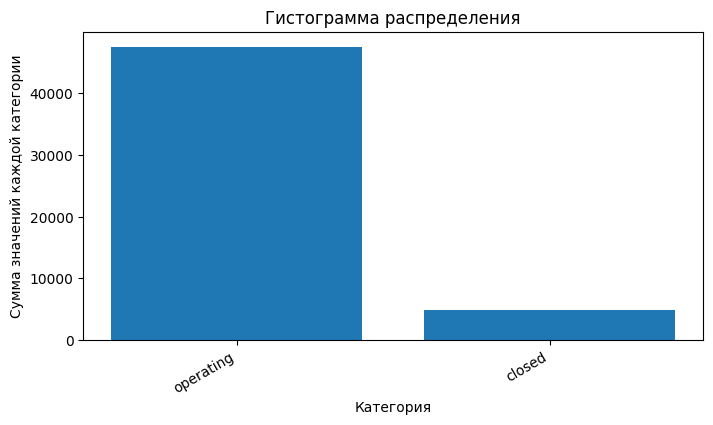

In [18]:
#график для статуса компании
print(f'Распределение в колонке "status"')
value_counts = train_data['status'].value_counts()
plt.figure(figsize=(8, 4))
plt.bar(value_counts.index, value_counts.values)
plt.title('Гистограмма распределения')
plt.xticks(rotation=30, ha='right')
plt.xlabel('Категория')
plt.ylabel('Сумма значений каждой категории')
plt.show()

На данный момент не функционирующих компаний-стартапов около 5000.

Из-за того что в остальных текстовых колонках слишком много категорий для графика, стоит рассмотреть только самые популярные из них, поэтому ограничим выборку для графика, условно, топ-20 категориями для анализа.

In [19]:
#постоим график колонки new_categories_list
def bar_build(data, list):
    for ittor in list:
        column_to_plot = (data.
        groupby(ittor)
        .agg(column_count=(ittor, 'count'))
        .sort_values(by='column_count', ascending=False).head(20)
        )
        print(f'Распределение в колонке {ittor}')
        plt.figure(figsize=(8, 4))
        plt.bar(column_to_plot.index, column_to_plot['column_count'])
        plt.grid(True)
        plt.title('Гистограмма распределения')
        plt.xticks(rotation=30, ha='right')
        plt.xlabel('Категория')
        plt.ylabel('Сумма значений каждой категории')
        plt.show()

Распределение в колонке new_category_list


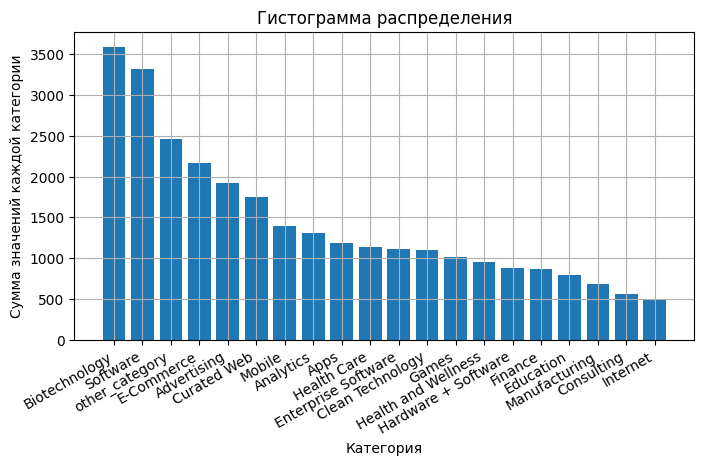

Распределение в колонке country_code


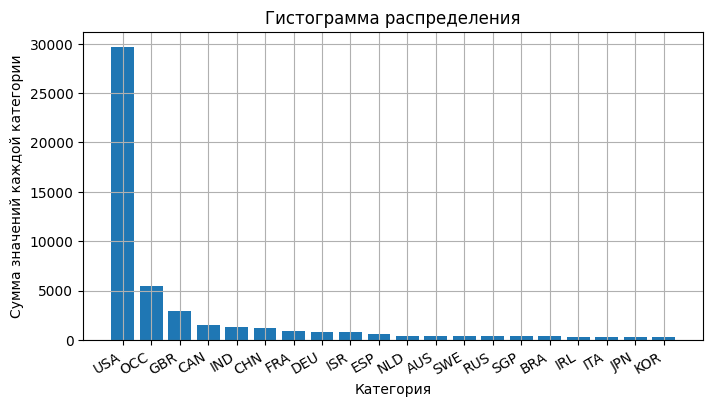

Распределение в колонке state_code


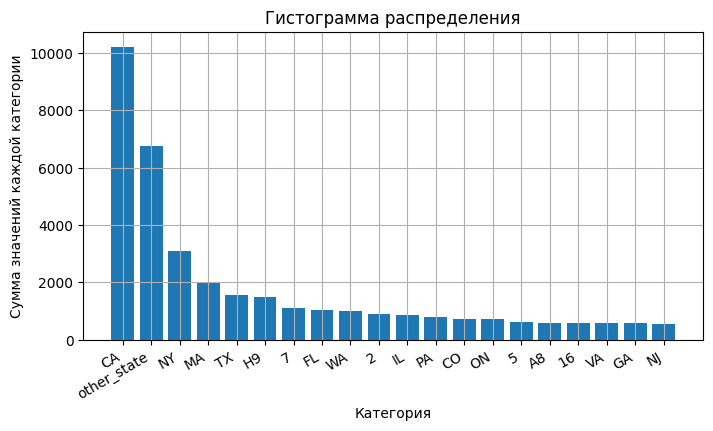

Распределение в колонке region


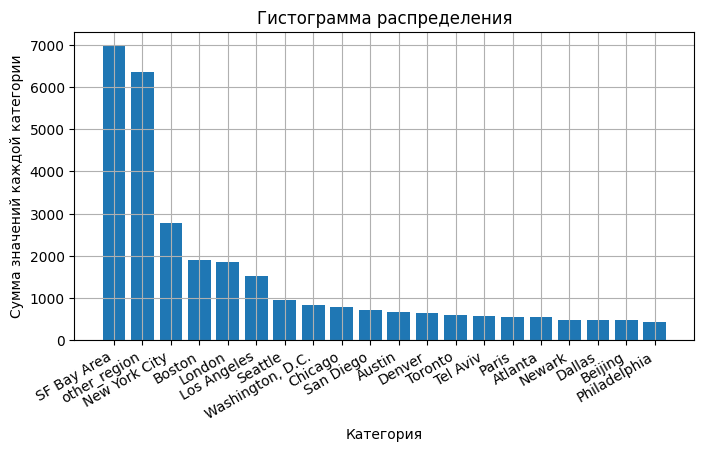

Распределение в колонке city


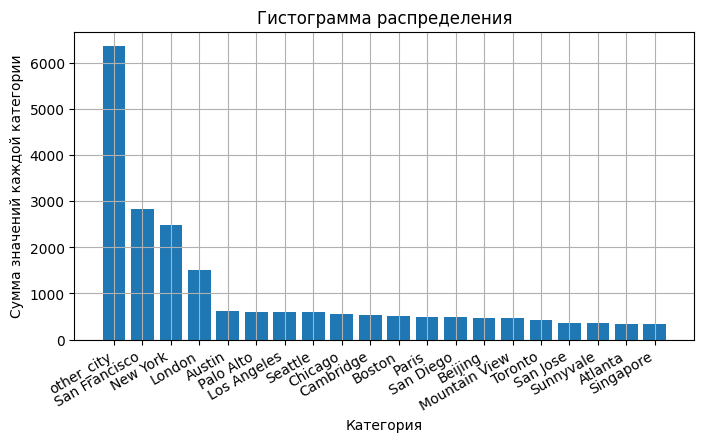

In [20]:
bar_build(train_data, ['new_category_list', 'country_code', 'state_code', 'region', 'city'])

Исходя из полученных графиков можно сделать следующие выводы:
* Самые частые категории стартапов это биотехнологии, програмное обеспечение и электронная коммерция;
* Самая большое число стартапов из США;
* Самый популярный штат Калифорния;
* Самый популярный регион это побережье Сан-Франциско, как раз штата Калифорния;
* Если бы не замененные пропущенные значения, самым популярным окакзался бы город Сан-Франциско.

Исследуем числовые признаки в таблице

Колонка - "funding_total_usd"


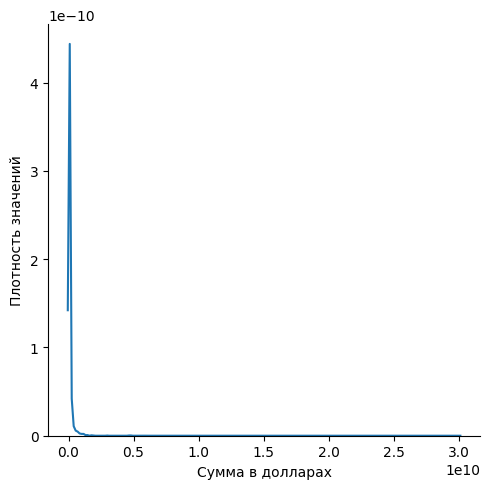

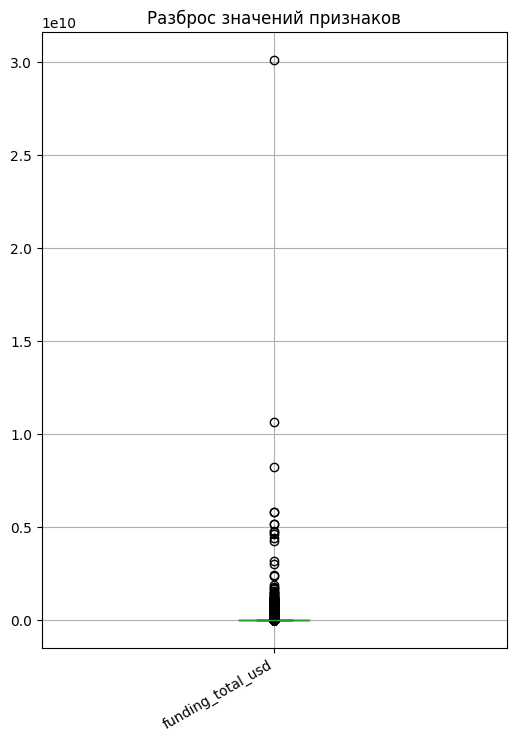

In [21]:
#исследуем непрерывный признак в тренировочном датасете
print(f'Колонка - "funding_total_usd"')
sns.displot(data=train_data, x="funding_total_usd", kind='kde')
plt.xlabel('Сумма в долларах')
plt.ylabel('Плотность значений')
plt.show()

train_data['funding_total_usd'].plot(kind='box', figsize=(6, 8))
plt.xticks(rotation=30, ha='right')
plt.title('Разброс значений признаков')
plt.grid('True')
plt.show()

Видим явный выброс или аномальное значение в данных. Стоит глянуть график сузив числовой диапазон до 20,000,000 usd и изучить снова.

Колонка - "funding_total_usd"


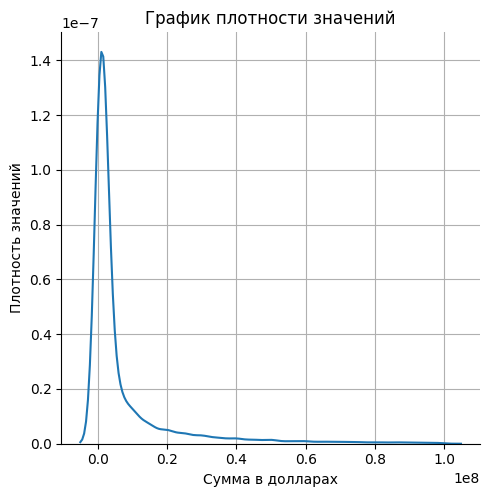

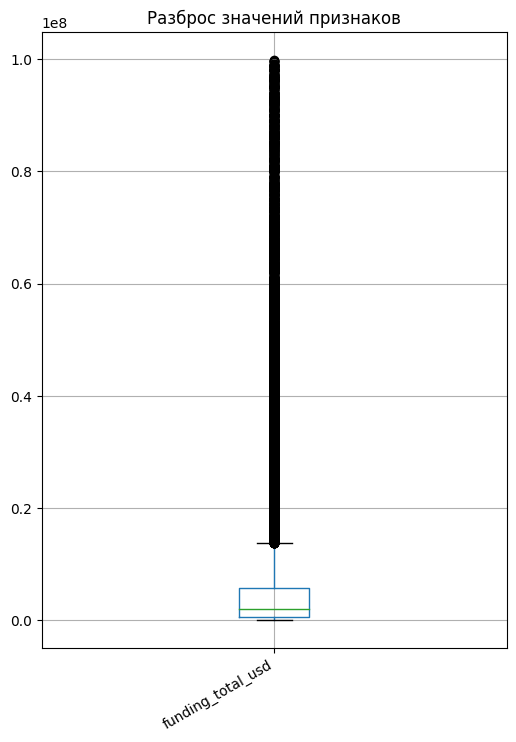

97.51 %


In [22]:
#исследуем непрерывный признак в тренировочном датасете с новой границей
print(f'Колонка - "funding_total_usd"')
data_query = train_data.query('funding_total_usd < 100_000_000')
sns.displot(data=data_query, x="funding_total_usd", kind='kde')
plt.title('График плотности значений')
plt.grid(True)
plt.xlabel('Сумма в долларах')
plt.ylabel('Плотность значений')
plt.show()

data_query['funding_total_usd'].plot(kind='box', figsize=(6, 8))
plt.xticks(rotation=30, ha='right')
plt.title('Разброс значений признаков')
plt.grid('True')
plt.show()
'''
посчитаем процент данных который остается при изменении среза данных, чтобы понимать сколько данных у нас остаеться для обучения,
приняв во внимание пропущенные значения, которые будут заполнены в пайплайне
'''
print(round((len(data_query) * 100 / (len(train_data) - train_data['funding_total_usd'].isnull().sum())), 2), '%')


Судя по "ящику с усами" в данных присутствуют выбросы начинающиеся примерно после 25 млн.длрв., но если выбрать именно эту границу - слишком большое кол-во данных будет отсечено, примерно 14%, поэтому условной границей выберем отметку в 100 млн.длрв., чтобы модель не переобучилась на слишком больших значениях, при этой отметке у нас остается 97% данных.

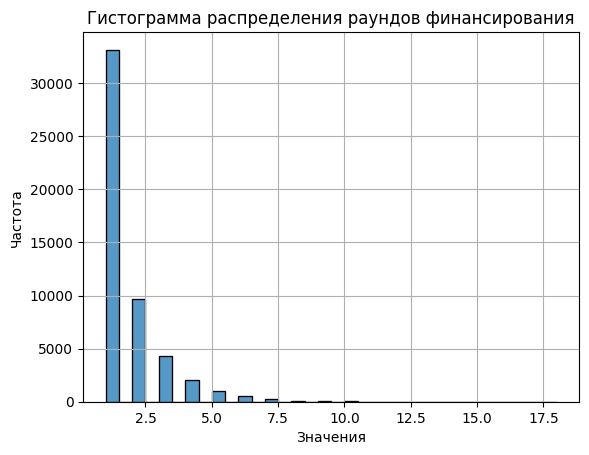

In [23]:
#график для кол-ва раундов финансирования
sns.histplot(data=data_query, x='funding_rounds', binwidth=0.5)
plt.grid(True)
plt.title('Гистограмма распределения раундов финансирования')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

Около 24 тыс. компаний имели всего один раунд финансирования. Два раунда около 9 тыс. Далее тенденция на понижение числа.

**Расмотрим теперь датасет с тестовыми данными**

Проверять категориальные колонки нет смысла, т.к. они копируют таковые из тренировочного датасета, поэтому проверим только числовые данные на наличие выбросов.

Колонка - "funding_total_usd"


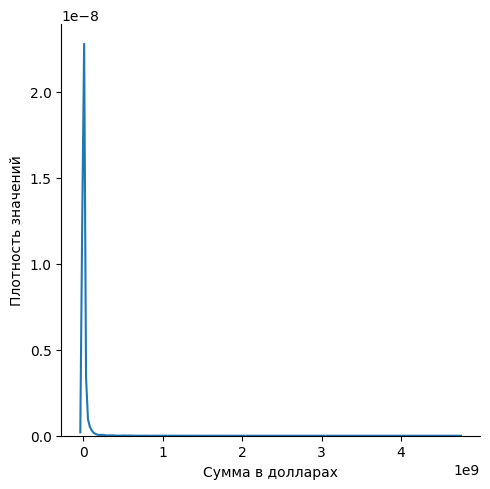

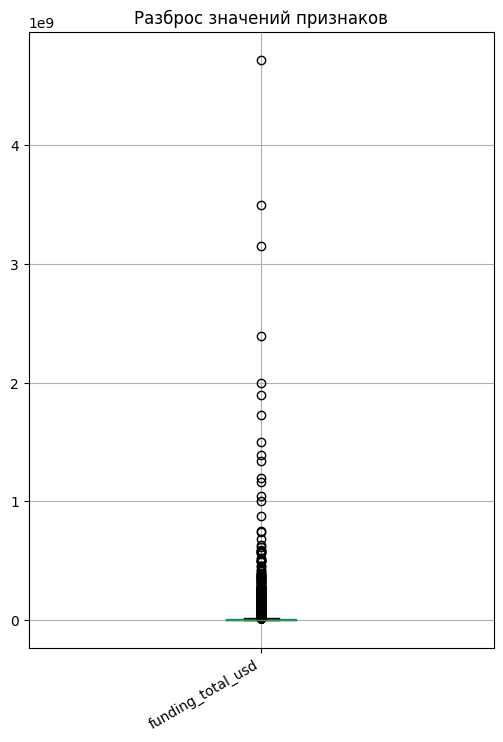

In [24]:
#исследуем распределения признака вложенных средств в тестовом датасете
print(f'Колонка - "funding_total_usd"')
sns.displot(data=test_data, x="funding_total_usd", kind='kde')
plt.xlabel('Сумма в долларах')
plt.ylabel('Плотность значений')
plt.show()

test_data['funding_total_usd'].plot(kind='box', figsize=(6, 8))
plt.xticks(rotation=30, ha='right')
plt.title('Разброс значений признаков')
plt.grid('True')
plt.show()

Так же видим выбросы значений, ограничим той же границей что и в тренировочном датасете.

Колонка - "funding_total_usd"


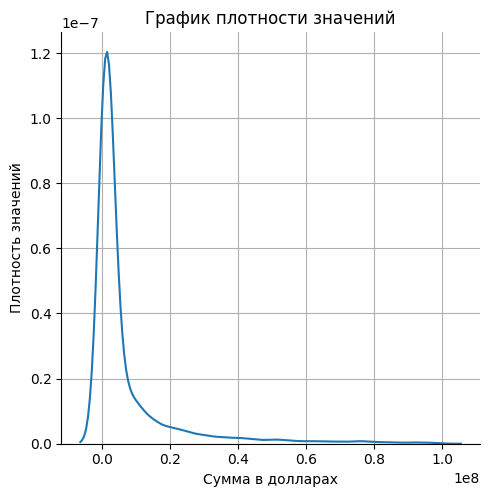

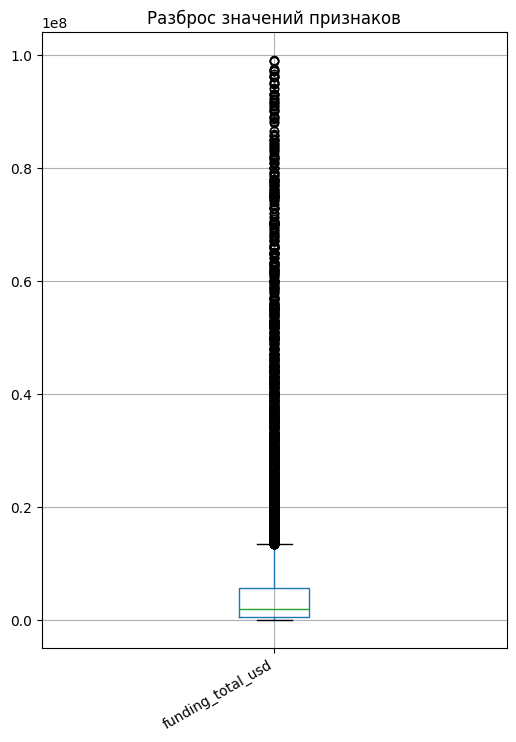

97.68 %


In [25]:
#исследуем непрерывный признак в тренировочном датасете с новой границей
print(f'Колонка - "funding_total_usd"')
data_query_test = test_data.query('funding_total_usd < 100_000_000')
sns.displot(data=data_query_test, x="funding_total_usd", kind='kde')
plt.title('График плотности значений')
plt.grid(True)
plt.xlabel('Сумма в долларах')
plt.ylabel('Плотность значений')
plt.show()

data_query_test['funding_total_usd'].plot(kind='box', figsize=(6, 8))
plt.xticks(rotation=30, ha='right')
plt.title('Разброс значений признаков')
plt.grid('True')
plt.show()

print(round((len(data_query_test) * 100 / (len(test_data) - test_data['funding_total_usd'].isnull().sum())), 2), '%')

Та же ситуация, ниже 20_000_000 находятся около 80% вложенных средст.

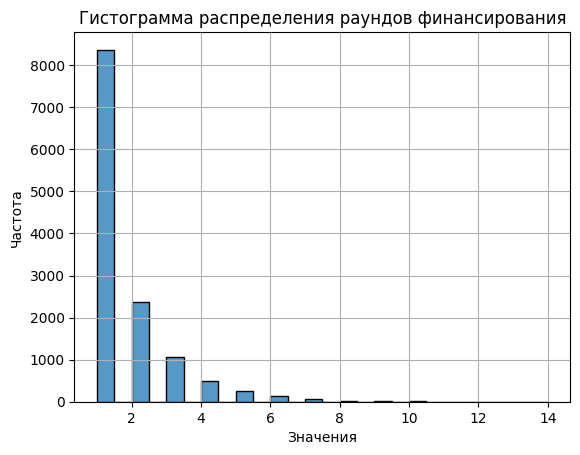

In [26]:
#проверим колонку с числом раундов
#график для кол-ва раундов финансирования
sns.histplot(data=data_query_test, x='funding_rounds', binwidth=0.5)
plt.grid(True)
plt.title('Гистограмма распределения раундов финансирования')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

Ситуция с раундами схожа с тренировочными данными, значит данные совпадают и подходят для проверки модели на качество.

In [27]:
display(data_query.info())
data_query_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51205 entries, 0 to 52515
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   51205 non-null  object        
 1   category_list          51205 non-null  object        
 2   funding_total_usd      51205 non-null  float64       
 3   status                 51205 non-null  object        
 4   country_code           51205 non-null  object        
 5   state_code             51205 non-null  object        
 6   region                 51205 non-null  object        
 7   city                   51205 non-null  object        
 8   funding_rounds         51205 non-null  int64         
 9   founded_at             51205 non-null  datetime64[ns]
 10  first_funding_at       51205 non-null  datetime64[ns]
 11  last_funding_at        51205 non-null  datetime64[ns]
 12  closed_at              51205 non-null  object        
 13  n

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12821 entries, 0 to 13124
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   12821 non-null  object        
 1   category_list          12821 non-null  object        
 2   funding_total_usd      12821 non-null  float64       
 3   country_code           12821 non-null  object        
 4   state_code             12821 non-null  object        
 5   region                 12821 non-null  object        
 6   city                   12821 non-null  object        
 7   funding_rounds         12821 non-null  int64         
 8   first_funding_at       12821 non-null  datetime64[ns]
 9   last_funding_at        12821 non-null  datetime64[ns]
 10  lifetime               12821 non-null  int64         
 11  new_category_list      12821 non-null  object        
 12  year_last_funding_at   12821 non-null  int64         
 13  m

### 4. Построим матрицу корреляций признаков, чтобы выявить мультиколлинеарность и выявить налиичие какой-либо свзяи признаков с целевым.

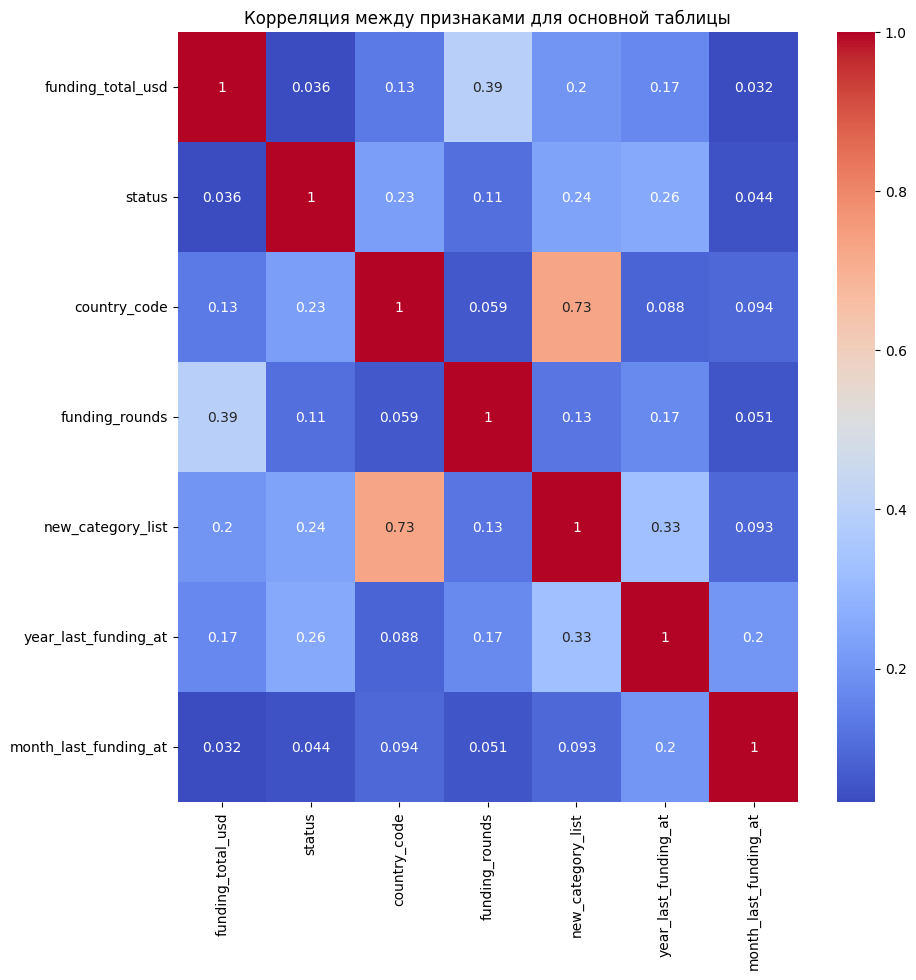

In [28]:
'''
используем для этого более подходящую библитеку phik,
которая может найти коэффициент корреляции между числовыми и категориальными признаками
'''
data_query_corr = data_query.drop(['name', 'founded_at', 'first_funding_at', 'last_funding_at', 'closed_at', 'category_list', 'city', 'region', 'state_code'], axis=1)
data_query_corr = data_query_corr.phik_matrix(
    interval_cols=['funding_total_usd']
)
plt.figure(figsize=(10, 10))
sns.heatmap(data_query_corr, annot=True, cmap='coolwarm')
plt.title('Корреляция между признаками для основной таблицы')
plt.show()

Колонки с регионом, штатом и городом сильно коррелирут с кодом страны вызывая мультиколлинеарность, поэтому их не стоит добавлять в общий набор признаков для обучения модели. 

Судя по таблице лучше всего коррелирует с целевым признаком дата последнего раунда финансирования, категория и страна компании.

### 5. Обучение модели и предсказание первых результатов. 

Для обучения наиболее подходящей модели воспользуемся методом перебора параметров RandomizedSearch, а саму подготовку данных выполним в пайплайне

In [29]:
#подготовка данных в пайплайне
#поставим имена компаний как индексы 
data_query = data_query.set_index('name')
data_query_for_model = data_query.drop(['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at', 'category_list', 'city', 'region', 'state_code'], axis=1)
data_query_test = data_query_test.set_index('name')
data_query_test_for_model = data_query_test.drop(['first_funding_at', 'last_funding_at', 'lifetime', 'category_list', 'city', 'region', 'state_code'], axis=1)


#разделим данные на две выборки
X_train, X_valid, y_train, y_valid = train_test_split(
    data_query_for_model.drop(['status'], axis=1),
    data_query_for_model['status'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data_query_for_model['status'])

In [30]:
#выделим колонки для енкодеров
ohe_columns = ['country_code',
               'new_category_list']
num_columns = ['funding_total_usd',
               'funding_rounds',
               'year_last_funding_at',
               'month_last_funding_at']

In [31]:
#создаем первый пайплайн
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(categories='auto', drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)
##общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)
#создаем финальный пайплайн
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [32]:
#саздадим гиперпараметры для моделей и для перебора методов масштабирования для числовых признаков
param_grid = [
    {
        'models':[DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
    },
    {
        'models':[KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l2'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [33]:
#через автоматический перебор моделей найдем лучшую
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    scoring='f1_weighted',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [34]:
randomized_search.fit(X_train, y_train)
#выведем лучшую модель и её параметры
print('Метрика F1 для лучшей модели:\n', randomized_search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Метрика F1 для лучшей модели:
 0.860697235687014

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country_code',
                                                   'new_category_list']),
                                                 

In [35]:
#проверим лучшую модель на валидационной выборке и выведем её F1_score
y_valid_pred = randomized_search.predict(X_valid)
print(f'Метрика F1 на валидационной выборке: {f1_score(y_valid, y_valid_pred, average="weighted")}')

Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros


Метрика F1 на валидационной выборке: 0.8604562008817329


Лучшей моделью для предсказания статуса компании стала **DecisionTreeClassifier** c параметрами - (max_depth=6, max_features=8, random_state=42). Точность модели на валидационной выборке согласно метрики F1 - 0.86. 

In [36]:
y_test_pred = randomized_search.predict(data_query_test_for_model)
predictions  = pd.Series(y_test_pred, index=data_query_test_for_model.index)
display(predictions)
predictions.to_csv('Predictions_on_startups.csv', index=True)

Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros


name
Crystalsol                operating
JBI Fish & Wings          operating
COINPLUS                  operating
Imagine Communications    operating
DNA13                     operating
                            ...    
Jymob                     operating
GlobaTrek                 operating
Inkd.com                  operating
AdWill                    operating
RingCentral               operating
Length: 12821, dtype: object

<div class='alert-info'>
*Shap график важности признаков будет добавлен, как и вывод к проделанной работе, но времени к сожалению не хватило, так что отправляю то что успел сделать, чтобы хотя-бы большую часть работы, согласно ваших рекомендаций мог править и дорабатывать. Проект не будет заброшен и будет дорабатываться в процессе обучения, но не за две недели, для меня это было физически невозможно, тут сплошал, но останавливаться не собираюсь и даю обещание сделать все как полагается, сам проект будет обновляться в репозитории github-а с коммитами, так что если не поверите там все будет)*